In [1]:
import glob
import os
import pandas as pd
import PIL 
from PIL import Image, ImageDraw
from collections import Counter
import numpy as np
from helpers import read_project_variables, return_whole_dataset, count_IoU
variables = read_project_variables()

In [2]:
from matplotlib import pyplot as plt


In [3]:
from utils.hough_transform_floor import HoughCircleDetecor

In [4]:
files = glob.glob('test_data/*')
files

['test_data\\IMG_20230102_014143_jpg.rf.40339675b8e529b778e3b0cd01b254fb.jpg',
 'test_data\\IMG_20230102_014201_jpg.rf.72245ef9bac3cd0ab2a8f365515a36db.jpg']

In [5]:
dict_lst = []
for image in files:
    houghCircle = HoughCircleDetecor(r_range=[150, 300], no_thetas=40,\
                                     no_circles=40, treshold=.15, pixel_treshold=80, background_type='desk')
    final_list = houghCircle(image)
    for circle in final_list:
        x, y, r = circle
        #output_img = cv2.circle(input_img, (x, y), r, (0, 255, 0), 2)
        dict_ = {"file":image,
                "x_min": x - r,
               "x_max": x + r,
               "y_min": y - r,
               "y_max": y + r}

        dict_lst.append(dict_)
circles = pd.DataFrame(dict_lst)

In [6]:
circles

,file,x_min,x_max,y_min,y_max
0,test_data\IMG_20230102_014143_jpg.rf.40339675b...,1694,2146,441,893
1,test_data\IMG_20230102_014143_jpg.rf.40339675b...,540,908,885,1253
2,test_data\IMG_20230102_014143_jpg.rf.40339675b...,2189,2673,2264,2748
3,test_data\IMG_20230102_014143_jpg.rf.40339675b...,3105,3589,1064,1548
4,test_data\IMG_20230102_014201_jpg.rf.72245ef9b...,472,864,1449,1841
5,test_data\IMG_20230102_014201_jpg.rf.72245ef9b...,1649,2055,2409,2815
6,test_data\IMG_20230102_014201_jpg.rf.72245ef9b...,1006,1498,540,1032


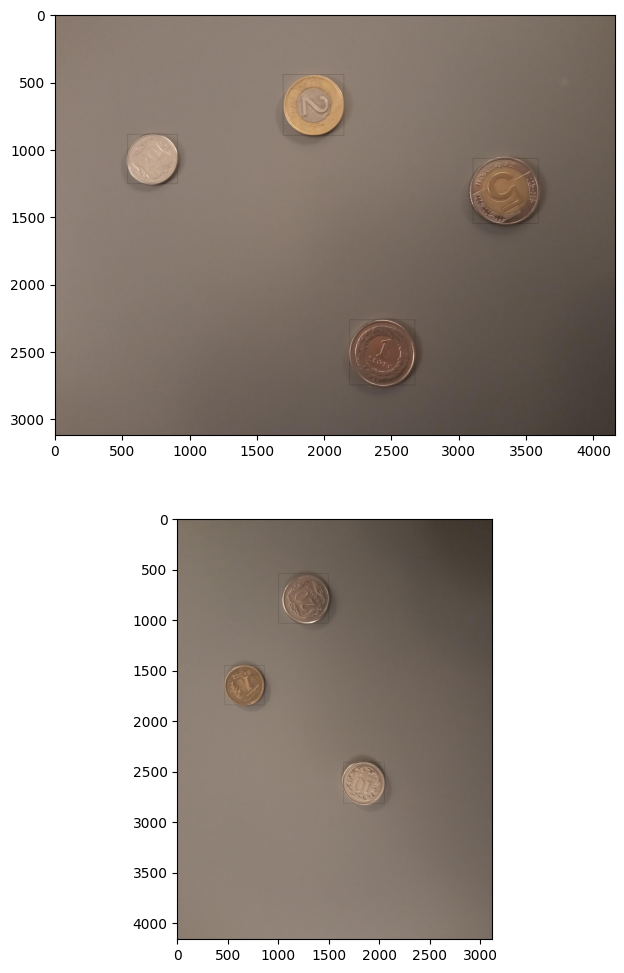

In [7]:
fig, axs = plt.subplots(nrows=len(files), figsize=(9,6*len(files)))
for i, file in enumerate(files): 
    image = Image.open(file)
    image_draw = ImageDraw.Draw(image)
    for bb in circles[circles['file'] == file][['x_min','y_min','x_max','y_max']].values:
        image_draw.rectangle(bb, outline=(0,0,0,0))
    axs[i].imshow(image)

In [9]:
small_images = {file: [] for file in files} 
for file in files:
    tmp = circles[circles['file'] == file]
    big_image = Image.open(file)
    for i, row in tmp.iterrows():
        small_images[file].append(big_image.crop(row[['x_min','y_min','x_max','y_max']].values))
small_images

{'test_data\\IMG_20230102_014143_jpg.rf.40339675b8e529b778e3b0cd01b254fb.jpg': [<PIL.Image.Image image mode=RGB size=452x452>,
  <PIL.Image.Image image mode=RGB size=368x368>,
  <PIL.Image.Image image mode=RGB size=484x484>,
  <PIL.Image.Image image mode=RGB size=484x484>],
 'test_data\\IMG_20230102_014201_jpg.rf.72245ef9bac3cd0ab2a8f365515a36db.jpg': [<PIL.Image.Image image mode=RGB size=392x392>,
  <PIL.Image.Image image mode=RGB size=406x406>,
  <PIL.Image.Image image mode=RGB size=492x492>]}

In [10]:
import pickle
def load_model(file): 
    with open(file, 'rb') as f: 
        return pickle.load(f)

In [11]:
from helpers import PCA, NearestCentroid

In [12]:
pca = load_model('models/pca_50x50_desk.pickle')
scaler = load_model('models/scaler_model_NC_comp_1000_dataset_desk.pickle')
clf = load_model('models/model_NC_comp_1000_dataset_desk.pickle')

In [13]:
coin_to_label = {'1gr': 0,'2gr': 1, '5gr': 2, '10gr': 3, '20gr': 4, '50gr': 5, '1zl': 6,'2zl': 7, '5zl': 8}
label_to_coin = {y:x for x, y in coin_to_label.items()}

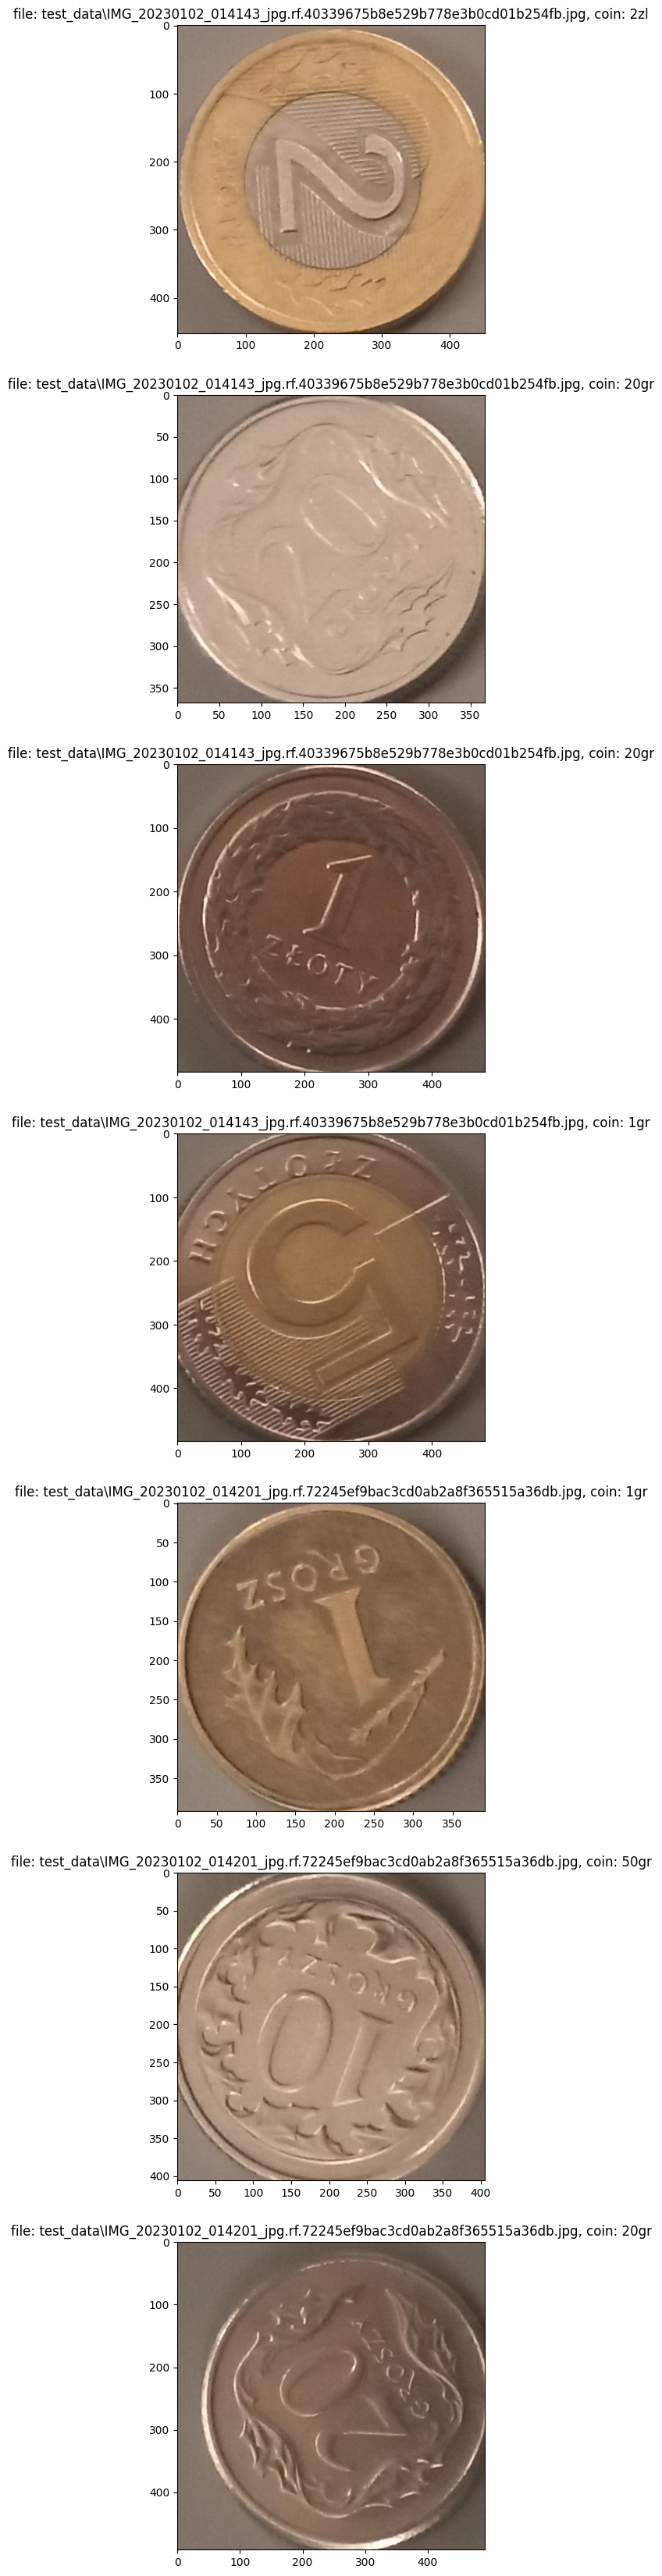

In [14]:
n_images =len(sum(small_images.values(), []))
fig, axs = plt.subplots(nrows=n_images, figsize=(9, 6*n_images))
i = 0 
for file, images in small_images.items(): 
    for image in images: 
        x = np.array(image.resize((50,50))).flatten()
        x = pca.transform(x, 1000).real
        x = scaler.transform(x.reshape(1, -1))
        label = clf.predict(x)[0]
        axs[i].imshow(image)
        axs[i].set_title(f'file: {file}, coin: {label_to_coin[label]}')
        i += 1